# Minimum volume ellipsoid (outlier detection)



In [1]:
%matplotlib inline

# Future 
from __future__ import print_function

# Numpy imports 
import numpy as np
import numpy.random as random

import scipy as sp
import scipy.linalg as la



# Convex optimization package: CVXOPT

## Import the basic packages
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

## Import the CVXOPT version of LAPACK
from cvxopt import blas, lapack, sqrt, mul, cos, sin, log

# Import matplotlib.pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# My imports 
from ellipsoidal_outlier_detector import FEllipsoid



EPS = sp.finfo(float).eps



# 2D scatter plot example 

Print some rough problem size estimates:
d = 3
M = 500
Na= 9

d**2 = 9
Na**2 = 81


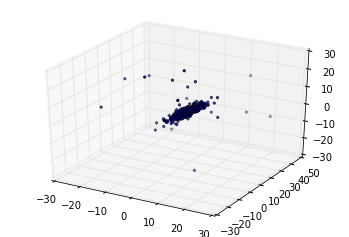

In [2]:
# Generate random samples for testing the algorithm 

Ndim = 3
Na = Ndim
Nsamples = 500


mean = np.array(Ndim * [5.0,])
cov = sp.eye(Ndim) + 5.0

samples = random.multivariate_normal(mean, cov, Nsamples)
samples[:20] = random.laplace(5, scale =10.0001, size=(20, mean.size))
#plt.plot(samples[:, 0], samples[:, 1], 'or', markersize=4)
#plt.axis('equal')


# Make a 3D figure
fig = plt.figure(0)
fig.clear()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(samples[:,0], 
           samples[:,1],
           samples[:,2], marker='.')

## Problem size estimates
print("Print some rough problem size estimates:")

d = Ndim
M = Nsamples

Na = int(d * (d+1) / 2.0 + d)

print("d = {0}\nM = {1}\nNa= {2}".format(d, M, Na), end='\n\n')
print("d**2 = {0}".format(d**2))
print("Na**2 = {0}".format(Na**2))

In [3]:
F = FEllipsoid(samples)

# Test the initial ellipse
vm = sp.inner(F.A0, F.xarray) + F.b0[:, None] 
gm = (vm*vm).sum(0) - 1
print(gm.max())




2.22044604925e-16


In [4]:
ztest = sp.rand(F.M+1)

# Test the faster hessian calculations for i.e. constraints
out_old = F.hess_f1_slow(F.a0, ztest)
out_new = F.hess_f1(F.a0, ztest)
relerr_new_hess = abs(out_old - out_new).sum() / abs(out_old).sum()

# Test the faster gradient calculations for i.e. constraints
out_old = F.grad_f1_slow(F.a0)
out_new = F.grad_f1(F.a0)

relerr_new_grad = abs(out_old - out_new).sum() / abs(out_old).sum()




print("Fast Hessian error : {0}.".format(relerr_new_hess))
print("Fast Gradient error: {0}.".format(relerr_new_grad))






print(F)

Fast Hessian error : 4.24109241851e-16.
Fast Gradient error: 1.71782372396e-16.


In [5]:
def get_optimal_ellipse(F, solvers=solvers):
    "Call the solver."
    sol = solvers.cp(F)
    solx = np.array(sol['x']).flatten()
    b = F.get_b(solx)
    A = F.get_A(solx)
    Ainv = la.inv(A)
    return A, b, Ainv

%prun A, b, Ainv = get_optimal_ellipse(F)
    
print(A.shape)
print(Ainv.shape)
print(b.shape)

 (3, 3)
(3, 3)
(3,)


In [6]:
ztest = sp.rand(F.M+1)
print("\nHessian slow:")
%time out = F.hess_f1_slow(F.a0, ztest)
print("\nHessian fast:")
%time out = F.hess_f1(F.a0, ztest)
print("\nGradient slow:")
%time out = F.grad_f1_slow(F.a0)
print("\nGradient fast:")
%time out = F.grad_f1(F.a0)




Hessian slow:
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 961 µs

Hessian fast:
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 207 µs

Gradient slow:
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 660 µs

Gradient fast:
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 248 µs


## Solve for the minimum volume ellipsoid containing all the points


# Make a plot showing min. vol ellipsoid

# Determine candidats for removal

In [7]:
def xinxout(x, A=A, b=b):
    "Define the signed distance to the boundary."
    v = sp.dot(A, x.T) + b[:, None]
    Iin = la.norm(v, axis=0) <  (1 - 100 * sp.sqrt(EPS))
    Iout = la.norm(v, axis=0) >=  (1 - 100 * sp.sqrt(EPS))

    xin = x[Iin, :]
    xout = x[Iout, :]
    return xin, xout

xin, xout = xinxout(samples)

print("Number of outliers :   {0}".format(xout.shape[0]))
print("Number of inliers  :   {0}".format(xin.shape[0]))



Number of outliers :   6
Number of inliers  :   494


Print some rough problem size estimates:
d = 3
M = 500
Na= 9

d**2 = 9
Na**2 = 81


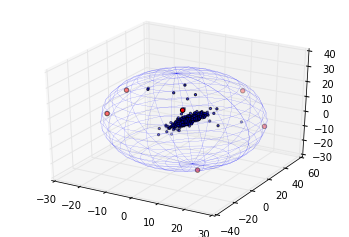

In [8]:
def plot_xinxout(xin, xout, Ainv, b):
    "Make a 3D scatter plot with some data"
    
    
    # Make a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(xin[:,0], xin[:,1], xin[:,2], marker='.')
    ax.scatter(xout[:,0], xout[:,1], xout[:,2], marker='o', c='r')

    
    ## Get points on a sphere
    thetas = sp.linspace(100*EPS, (1.0-100*EPS) * sp.pi, 20)
    phis = sp.linspace(0.0, 2*sp.pi, 20)

    TT, PP = sp.meshgrid(thetas, phis, indexing='ij')

    xx = sp.cos(PP) * sp.sin(TT)
    yy = sp.sin(PP) * sp.sin(TT)
    zz = sp.cos(TT)


    Ainv_xx = Ainv[:,0, None, None] * (xx - b[None, None, 0])
    Ainv_yy = Ainv[:,1, None, None] * (yy - b[None, None, 1])
    Ainv_zz = Ainv[:,2, None, None] * (zz - b[None, None, 2])

    xyz_ellipse = Ainv_xx + Ainv_yy + Ainv_zz
    xe = xyz_ellipse[0]
    ye = xyz_ellipse[1]
    ze = xyz_ellipse[2]

    
    ax.plot_wireframe(xe, ye, ze, linewidth=0.1)
    
    
    return fig
    
    
plot_xinxout(xin, xout, Ainv, b)
    
## Problem size estimates
print("Print some rough problem size estimates:")

d = Ndim
M = Nsamples

Na = int(d * (d+1) / 2.0 + d)

print("d = {0}\nM = {1}\nNa= {2}".format(d, M, Na), end='\n\n')
print("d**2 = {0}".format(d**2))
print("Na**2 = {0}".format(Na**2))

In [9]:
F_ellipsoid = FEllipsoid(samples)


def get_optimal_ellipse(F, solvers=solvers):
    "Call the solver."
    
    # Solve the convex optimization for ellipse
    sol = solvers.cp(F)
    astar = np.array(sol['x']).flatten()
    
    
    
    # Compute the standard ellipse parameters
    b = F.get_b(astar)
    A = F.get_A(astar)
    pstar = 1.0 / la.det(A)
    
    return astar, pstar, A, b

def xinxout(F, A, b):
    "Define the signed distance to the boundary."
    x = F.xarray
    v = sp.dot(A, x.T) + b[:, None]
    Iin = (v**2).sum(0)-1 <  - 10 * sp.sqrt(EPS)
    Iout = (v**2).sum(0)-1 >= - 10 * sp.sqrt(EPS)
    xin = x[Iin, :]
    xout = x[Iout, :]
    return xin, xout


def get_total_partition(xarray, 
                        get_optimal_ellipse = get_optimal_ellipse,
                        xinxout = xinxout, 
                        FEllipsoid = FEllipsoid):
    """
    Compute outliers in sequance for all points.
    
    in
    --
    xarray    - array shaped (M, d) for M samples of d-dimensional vecs

    out
    ---
    xpart_list  - list of partitions 
    volumes     - array of ellipsoid volumes
    A_arrs      - A_arrs define the covarience of ellipse
    b_vecs      - b_vecs define the center of the ellipse
    Fe          - The interface to CVXOPT
    
    """
    
    # Define an interface to cvxopt
    Fe = FEllipsoid(xarray)
    Mstart = Fe.M
    
    
    # Initialize output
    xout_list = []
    xin_list = []
    pstars = sp.zeros((Fe.M,))
    A_arrs = sp.zeros((Fe.M, Fe.ndim, Fe.ndim))
    b_vecs = sp.zeros((Fe.M, Fe.ndim))
    
    
    # Loop until the set of points has been partitioned
    for i in range(Mstart):
        
        # Get the next ellipse
        astar, pstar, A, b = get_optimal_ellipse(Fe)
    
        # Separate points
        xin, xout = xinxout(Fe, A, b)
        
        # Make a new ellipsoid solver
        Fe = FEllipsoid(xin, a0=astar)
        
        # Store data for output
        xout_list.append(xout)
        xin_list.append(xin)
        pstars[i] = pstar
        A_arrs[i, :, :] = A
        b_vecs[i, :] = b
        
        if xin.shape[0] < Mstart / 2.0:
            ibound = i + 1            
            break
    
        
    # Prepare output
    pstars = pstars[:ibound]
    A_arrs = A_arrs[:ibound, :, :]
    b_vecs = b_vecs[:ibound, :]
    
    return xin_list, xout_list, pstars, A_arrs, b_vecs

In [10]:
out = get_total_partition(samples)

In [11]:
xins, xouts, ps, As, bs = out[:]

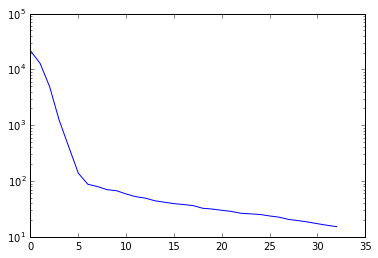

In [12]:
plt.semilogy(ps)

In [13]:
nout = [len(_xout) for _xout in xouts]
nin = [len(_xin) for _xin in xins]

In [14]:
zip(nin, nout)

[(495, 5),
 (490, 5),
 (484, 6),
 (479, 5),
 (474, 5),
 (466, 8),
 (458, 8),
 (451, 7),
 (443, 8),
 (434, 9),
 (427, 7),
 (419, 8),
 (411, 8),
 (403, 8),
 (396, 7),
 (388, 8),
 (379, 9),
 (370, 9),
 (361, 9),
 (354, 7),
 (347, 7),
 (339, 8),
 (331, 8),
 (322, 9),
 (315, 7),
 (307, 8),
 (298, 9),
 (289, 9),
 (281, 8),
 (272, 9),
 (265, 7),
 (256, 9),
 (249, 7)]

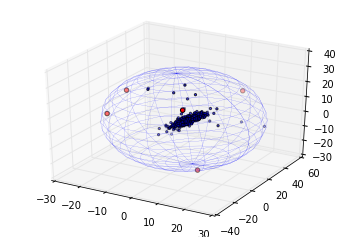

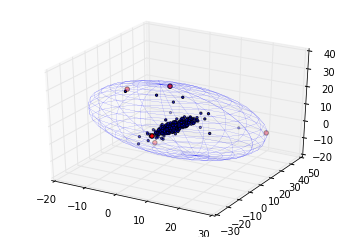

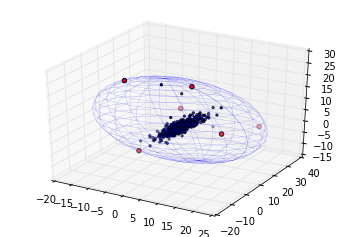

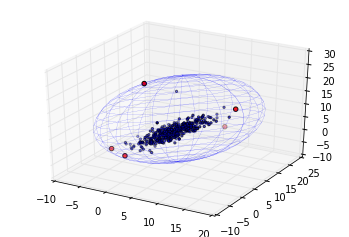

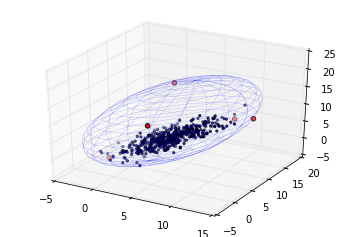

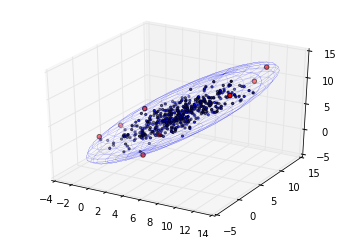

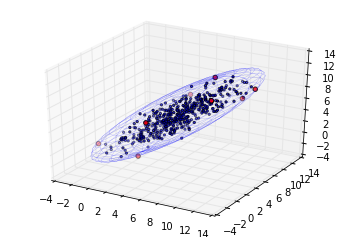

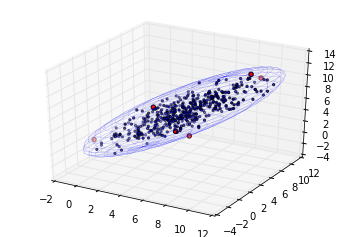

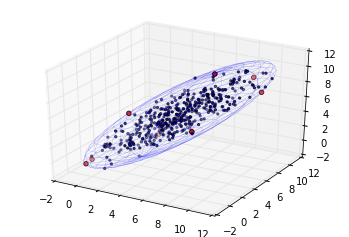

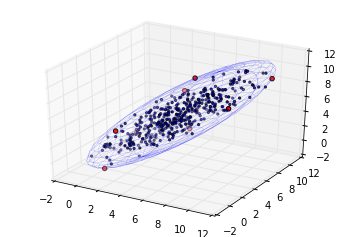

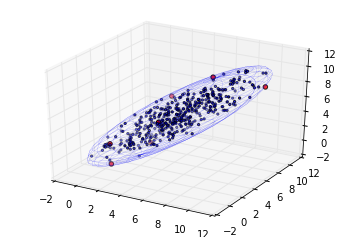

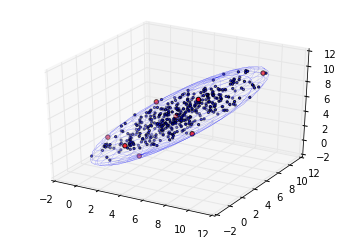

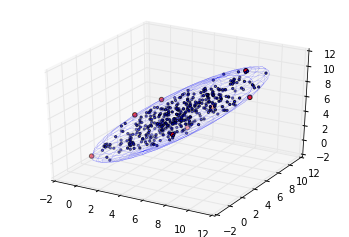

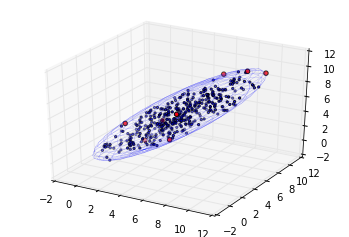

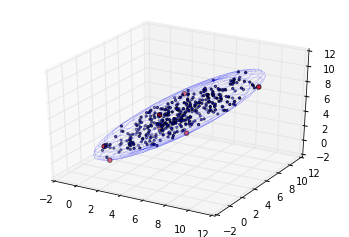

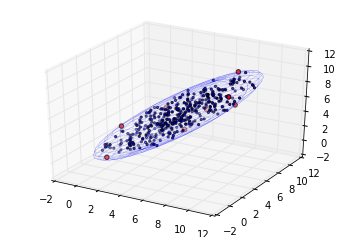

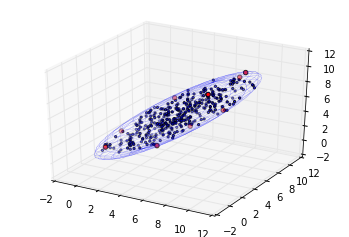

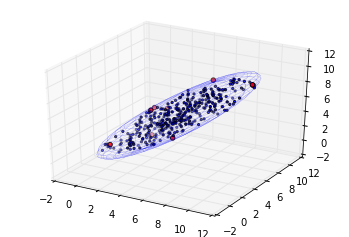

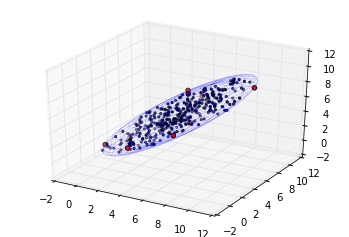

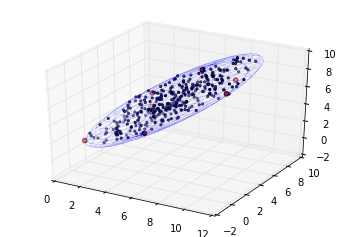

In [15]:
for i in range(len(xins))[:20]: #[0, 1, 2, 3, 10, 20]:
    fig = plot_xinxout(xins[i], xouts[i], la.inv(As[i]), bs[i])